# Program Trading Simulation


In [62]:
colab = False
skl = True

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !cp /content/drive/MyDrive/NCCU/Paper/Program_Trading/TechIndex.py .
    !wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
    !wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
    !dpkg -i libta.deb ta.deb
    !pip install ta-lib
    !pip install pandas_datareader --upgrade
    !pip install tensorflow_addons
    gd_root = '/content/drive/MyDrive/NCCU/Paper/Program_Trading'

if skl:
    import tensorflow as tf
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

## Import Packages

In [99]:
import pandas as pd
from collections import Counter
import numpy as np
import warnings
import pandas_datareader as pdr
import seaborn as sns
import os
import warnings
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from importlib import reload
import utility.techIndex
reload(utility.techIndex)
from utility.techIndex import *
import utility.datatools
reload(utility.datatools)
from utility.datatools import *
import utility.structure
reload(utility.structure)
from utility.structure import *
import utility.training
reload(utility.training)
from utility.training import *
import utility.strategy
reload(utility.strategy)
from utility.strategy import *
import config
reload(config)
from config import *

## Package Config Setting

In [100]:
# pandas setting
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth',50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None # ignore pandas warning

# numpy setting
np.set_printoptions(suppress=True)

# warning setting
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Model Training Phase

## Data Proprecess

In [115]:
def data_preprocess(stock_num,train_start,train_end,feature,days,train=True,scaler_x=None,scaler_y=None):
    X = []
# read csv
    df = pd.read_csv(os.path.join(gd_root,stock_root,stock_num+'.csv'), index_col=0)
    df = df.loc[train_start:train_end]
    
# turn to ratio    
    df = to_ratio(df) 
    
# technical indicator
    df = talib_index(df)

# make lable y
    df, df_y = y_price(df, days = days)
    
# filter input feature
    df = df[feature]
    
# exponential smoothing
    # for columnName in df.columns:
    #     df[str(columnName)] = exponential_smoothing(5, 0.2, list(df[str(columnName)]))

    # df = df.iloc[:-days]
    
# y sma
    # df_y  = df_y.rolling(5).mean().iloc[5:]
# y ema
    # df_y = df_y.ewm(span=5).mean().iloc[5:]

    # df = df.iloc[5:]
    
# df sma
    # df  = df.rolling(5).mean().iloc[5:]
# df ema
    # df = df.ewm(span=5).mean().iloc[5:]

# get y after time window
    y_ori = df_y[time_slide:].values

    # for column in new_df.columns:
    #     new_df = normalization(new_df)
    # use Sclaer to scaler both x & y
    if train:
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()
        scaler_x = scaler_x.fit(df)
        scaler_y = scaler_y.fit(y_ori.reshape(-1, 1))
        # scaler_df = scaler_x.transform(df)
        # y = scaler_y.transform(y_ori.reshape(-1, 1))
    scaler_df = scaler_x.transform(df)           
    y = scaler_y.transform(y_ori.reshape(-1,1))

# create training window
    for i in range(time_slide, len(scaler_df)): 
        tmp = scaler_df[i-time_slide:i]
        # tmp = normalization(tmp)
        X.append(tmp)
    return X, y, y_ori, scaler_x, scaler_y, df, df_y 

def training(stock, train_x, train_y, val_x, val_y, day):
    model, prefix = lstm_reg_v1(train_x,train_y)
    model_name = f'{prefix}_{stock}_{train_x.shape[1]}x{train_x.shape[2]}_{day}d_trainbest.h5'
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        0.0001,
        decay_steps=10,
        decay_rate=0.9,
        )
    
    model.compile(
        loss="mean_squared_error", 
        metrics = ["mean_squared_error"], 
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
        )
    
    history = model.fit(
        train_x, 
        train_y , 
        # shuffle = False,
        verbose=2, 
        epochs = 100, 
        batch_size = batch_size, 
        validation_data=(val_x, val_y), 
        callbacks = callback(os.path.join(gd_root,model_root,model_name))
        )
    
    model_history = pd.DataFrame(history.history)
    return model, model_name, model_history

## Model Building & Training

In [120]:
%%time
print_time(colab)
status(time_slide, feature)
# Load the TensorBoard notebook extension
%reload_ext tensorboard

counter = 1
train_start = '2001-01-01'
train_end = '2017-12-31'
# stockNum = ['1326','3008','6505','2912','2308','2382']
stockNum = ['1326']
stock = stockNum[0]

metric_st_list = []
metric_lt_list = []

for stock_num in stockNum:
    tf.keras.backend.clear_session()
    print(counter,str(stock_num),"preprocess")
    # Short Term Model
    day_st = 3
    X_st, y_st, y_st_ori, scaler_x_st, scaler_y_st, df_X_st, df_y_st = data_preprocess(stock_num, train_start, train_end, feature, days = day_st)
    train_x_st, train_y_st, val_x_st, val_y_st, price_y_st_tra, price_y_st = input_build(X_st, y_st, y_st_ori)
    model_st, model_st_name, model_st_history = training(stock_num, train_x_st, train_y_st, val_x_st, val_y_st, day_st)

    # Long Term Model
    day_lt = 5  
    X_lt, y_lt, y_lt_ori, scaler_x_lt, scaler_y_lt, df_X_lt, df_y_lt = data_preprocess(stock_num, train_start, train_end, feature, days=day_lt)
    train_x_lt, train_y_lt, val_x_lt, val_y_lt, price_y_lt_tra, price_y_lt = input_build(X_lt, y_lt, y_lt_ori)
    model_lt, model_lt_name, model_lt_history = training(stock_num, train_x_lt, train_y_lt, val_x_lt, val_y_lt, day_lt)
    
    # Model Stock Metric   
    model_st = tf.keras.models.load_model(os.path.join(gd_root,model_root,model_st_name))
    # result_st = model_st.evaluate(val_x_st, val_y_st)
    pred_y_st = model_st.predict(val_x_st)
    r2_st = r2_score(val_y_st, pred_y_st)

    model_lt = tf.keras.models.load_model(os.path.join(gd_root,model_root,model_lt_name))
    # result_lt = model_lt.evaluate(val_x_lt, val_y_lt)
    pred_y_lt = model_lt.predict(val_x_lt)
    r2_lt = r2_score(val_y_lt, pred_y_lt)
    
    metric_st_list.append([stock_num, f'{r2_st:.6f}'])
    metric_lt_list.append([stock_num, f'{r2_lt:.6f}'])
    counter += 1


2021/12/08 13:51:45
slide winodw: 5 days, 16 features

1 1326 preprocess
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.99050, saving model to .\model\lstm_v1_1326_5x16_3d_trainbest.h5
14/14 - 2s - loss: 1.0017 - mean_squared_error: 1.0017 - val_loss: 0.9905 - val_mean_squared_error: 0.9905
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.99050
14/14 - 0s - loss: 0.7860 - mean_squared_error: 0.7860 - val_loss: 1.0006 - val_mean_squared_error: 1.0006
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.99050
14/14 - 0s - loss: 0.7224 - mean_squared_error: 0.7224 - val_loss: 1.0086 - val_mean_squared_error: 1.0086
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.99050
14/14 - 0s - loss: 0.7102 - mean_squared_error: 0.7102 - val_loss: 1.0174 - val_mean_squared_error: 1.0174
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.99050
14/14 - 0s - loss: 0.7039 - mean_squared_error: 0.7039 - val_loss: 1.0194 - val_mean_squared_error: 1.0194
Epoch 6/100



## Training History

2021/12/08 13:53:34
slide winodw: 5 days, 16 features

Wall time: 82.1 ms


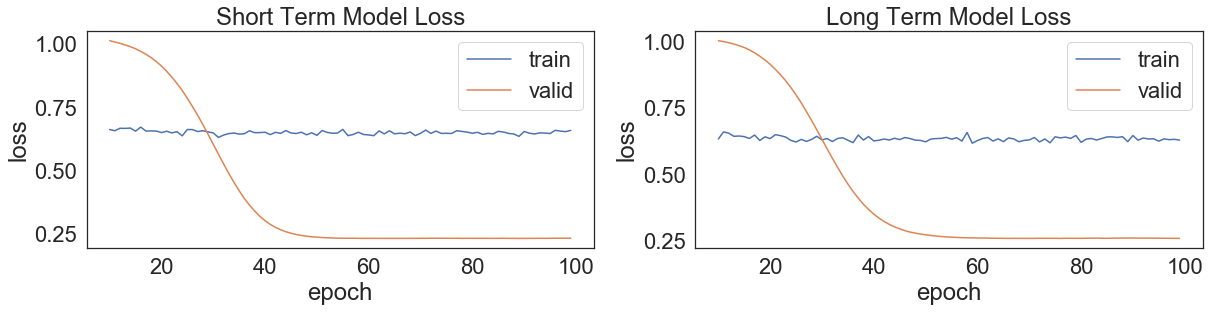

In [121]:
%%time
print_time(colab)
status(time_slide, feature)

sns.set(style = 'white',font_scale=2)
fig, ax = plt.subplots(1,2,figsize=(20, 4))
st_history = model_st_history.iloc[10:]
sns.lineplot(x=st_history.index , y = 'loss' ,data = st_history, ax = ax[0])
sns.lineplot(x=st_history.index , y = 'val_loss' ,data = st_history, ax = ax[0])
ax[0].set_title('Short Term Model Loss')
ax[0].set_xlabel ('epoch')
ax[0].set_ylabel ('loss')
ax[0].legend(['train', 'valid'], loc='upper right')

lt_history = model_lt_history.iloc[10:]
sns.lineplot(x=lt_history.index , y = 'loss' ,data = lt_history , ax = ax[1])
sns.lineplot(x=lt_history.index , y = 'val_loss' ,data = lt_history, ax = ax[1])
ax[1].set_title('Long Term Model Loss')
ax[1].set_xlabel ('epoch')
ax[1].set_ylabel ('loss')
ax[1].legend(['train', 'valid'], loc='upper right')

## Model Metric

2021/12/08 13:53:34
slide winodw: 5 days, 16 features

1326
lstm_v1_1326_5x16_3d_trainbest.h5
lstm_v1_1326_5x16_5d_trainbest.h5


,Short Term Before Inverse,Short Term After Inverse,Long Term Before Inverse,Long Term After Inverse
MSE,0.231,146.331,0.258,163.665
RMSE,0.480,12.097,0.508,12.793
R2,-0.279,-0.279,-0.430,-0.430


Wall time: 5.47 s


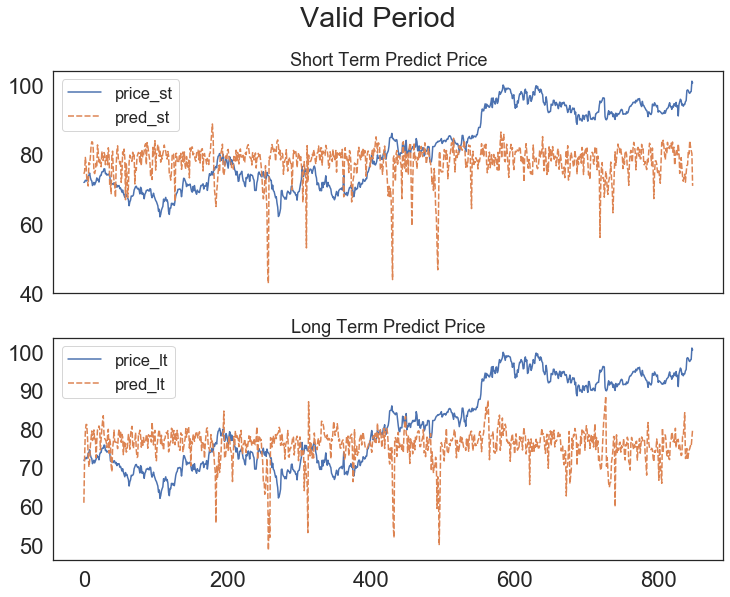

In [122]:
%%time
print_time(colab)
status(time_slide, feature)
if stock != None:
    print(stock)

prefix_list=['lstm_v1','conv1d_v1']
prefix=prefix_list[0]

model_st_name = f'{prefix}_{stock}_{time_slide}x{len(feature)}_3d_trainbest.h5'
model_st = tf.keras.models.load_model(os.path.join(gd_root,model_root,model_st_name))
print(model_st_name)
model_lt_name = f'{prefix}_{stock}_{time_slide}x{len(feature)}_5d_trainbest.h5'
model_lt = tf.keras.models.load_model(os.path.join(gd_root,model_root,model_lt_name))
print(model_lt_name)

pred_y_st = model_st.predict(val_x_st)
pred_y_st_inverse = scaler_y_st.inverse_transform(pred_y_st)

pred_y_lt = model_lt.predict(val_x_lt[:,:,:,np.newaxis])
pred_y_lt_inverse = scaler_y_lt.inverse_transform(pred_y_lt)

# Metric
metric = {
    'Short Term Before Inverse':[
        mean_squared_error(val_y_st, pred_y_st, squared = True),
        mean_squared_error(val_y_st, pred_y_st, squared = False),
        r2_score(val_y_st, pred_y_st)
    ],
    'Short Term After Inverse':[
        mean_squared_error(price_y_st, pred_y_st_inverse, squared = True),
        mean_squared_error(price_y_st, pred_y_st_inverse, squared = False),
        r2_score(price_y_st, pred_y_st_inverse)
    ],
    'Long Term Before Inverse':[
        mean_squared_error(val_y_lt, pred_y_lt, squared = True),
        mean_squared_error(val_y_lt, pred_y_lt, squared = False),
        r2_score(val_y_lt, pred_y_lt)
    ],
    'Long Term After Inverse':[
        mean_squared_error(price_y_lt, pred_y_lt_inverse, squared = True),
        mean_squared_error(price_y_lt, pred_y_lt_inverse, squared = False),
        r2_score(price_y_lt, pred_y_lt_inverse)
    ]
 }

df_metric = pd.DataFrame(metric,index=['MSE','RMSE','R2'])
display(df_metric)

df_st = pd.DataFrame({'price_st':price_y_st, 'pred_st':pred_y_st_inverse.reshape(len(pred_y_st_inverse))})
df_lt = pd.DataFrame({'price_lt':price_y_lt, 'pred_lt':pred_y_lt_inverse.reshape(len(pred_y_lt_inverse))})
fig, ax = plt.subplots(2,1,figsize=(12, 9), sharex=True)
fig.suptitle('Valid Period')
sns.set(style = 'white',font_scale=1.5)
ax[0].set_title('Short Term Predict Price')
sns.lineplot(data = df_st, ax = ax[0])
ax[1].set_title('Long Term Predict Price')
sns.lineplot(data = df_lt, ax = ax[1])

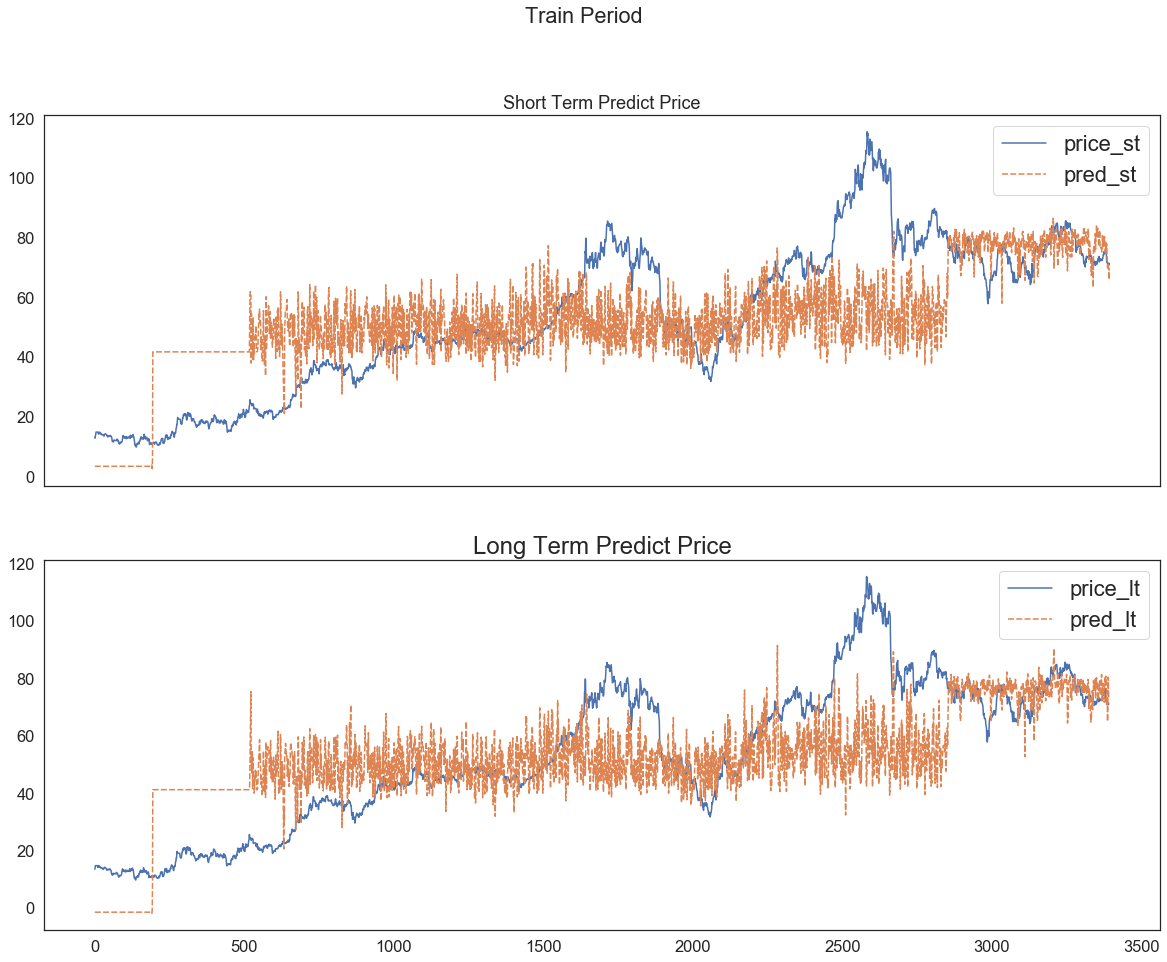

In [123]:
pred_y_st = model_st.predict(train_x_st)
pred_y_st_inverse = scaler_y_st.inverse_transform(pred_y_st)
pred_y_lt = model_lt.predict(train_x_lt)
pred_y_lt_inverse = scaler_y_lt.inverse_transform(pred_y_lt)

df_st = pd.DataFrame({'price_st':price_y_st_tra, 'pred_st':pred_y_st_inverse.reshape(len(pred_y_st_inverse))})
df_lt = pd.DataFrame({'price_lt':price_y_lt_tra, 'pred_lt':pred_y_lt_inverse.reshape(len(pred_y_lt_inverse))})
fig, ax = plt.subplots(2,1,figsize=(20, 15), sharex=True)
fig.suptitle('Train Period')
ax[0].set_title('Short Term Predict Price')
sns.set(style = 'white',font_scale=2)
sns.lineplot(data = df_st, ax = ax[0])
ax[1].set_title('Long Term Predict Price')
sns.lineplot(data = df_lt, ax = ax[1])

# Trading Performance

## Test Period Rate of Return

In [49]:

%%time
# setting backtest model

train_start = '2018-01-01'
train_end = '2019-12-31'
stockNum = ['2603']
# setting the information of data
asset_at_the_start = 1000000
total_asset_present_value = 0
record_ror = []
trading_ROR = {}
portfolio_list = []
compare_ror = []
counter = 0

for stock_num in stockNum:
    tf.keras.backend.clear_session()
    print(counter,str(stock_num),"preprocess")
    # Prepare Data
    # todo modify data preprocess, separate scaler & long short terms 
    day = 1
    X, y, y_ori, _, _, df, df_y = data_preprocess(stock_num, train_start, train_end, feature, days = day, train=False,scaler_x=scaler_x_st,scaler_y=scaler_y_st)

# start backtest evaluaion 
    left_money = asset_at_the_start*(1/len(stockNum))
    own_asset = left_money 
    own_stock = 0 
    # money_record = [left_money]*time_slide
    stock_record = [[x,left_money] for x in df.index[:time_slide]]
    # origin_hold_stock = 0 
    X = np.array(X)
    day_st = 3
    day_lt = 5
    model_st_name = f'conv1d_{stock_num}_{X.shape[1]}x{X.shape[2]}_{day_st}d_trainbest.h5'
    model_lt_name = f'conv1d_{stock_num}_{X.shape[1]}x{X.shape[2]}_{day_lt}d_trainbest.h5'
    model_st = tf.keras.models.load_model(os.path.join(gd_root,model_root,model_st_name))
    model_lt = tf.keras.models.load_model(os.path.join(gd_root,model_root,model_lt_name))
    # print(os.path.join(gd_root,model_root,model_st_name))
    # print(os.path.join(gd_root,model_root,model_lt_name))
    df_trade = df[time_slide:]
    for window in range(len(X)):
#         print(model_st.predict(X[window]))
        price_s = scaler_y_st.inverse_transform(model_st.predict(X[window][np.newaxis,:]))
        price_l = scaler_y_lt.inverse_transform(model_lt.predict(X[window][np.newaxis,:]))
        predict = (price_s,price_l)
        # predict = (model_st.predict(X[window][np.newaxis,:], model_lt.predict(X[window][np.newaxis,:]))
        price = df_trade['Close'][window]
        stock_assets, own_stock, left_money, action, pred, price = highlow_strategy(price_l, own_stock, left_money, price)
        stock_record.append([df_trade.index[window], stock_assets, action, pred, price])
    
    daily_assets = pd.DataFrame(stock_record, columns = ['date','assets','action','pred_price','close_price']).set_index('date')  
    portfolio_list.append(daily_assets)
    last_money = stock_record[-1][1]
    left_assets = int(last_money)-(own_asset)
    record_ror.append([str(stock_num), int(last_money), left_assets/own_asset])
    
    # compare to buy & hold strategy
    bench_df = pdr.DataReader(str(stock_num)+'.tw', 'yahoo', start=train_start, end=train_end)
    buyhold_ror = ((bench_df['Close'][-1]/bench_df['Close'][0])-1)*100
    stock_ror = (left_assets*100/(own_asset))

    print(f"{str(counter).zfill(2)} {str(stock_num)} 最後資產： {int(last_money)} 交易報酬率： {stock_ror} % 持有報酬率 {buyhold_ror:.4f} %")
    
    total_asset_present_value += int(last_money)
    trading_ROR[stock_num] = stock_ror
    compare_ror.append([stock_num, stock_ror, buyhold_ror])

trading_df = pd.DataFrame(compare_ror,columns=['stock','trading ror','buyhold ror'])

print("\n總投資報酬率：", (total_asset_present_value - asset_at_the_start)*100 / asset_at_the_start, "%\n")

Valid_Portfolio = portfolio_list[0].join(portfolio_list[1:])
Valid_Portfolio['total'] = Valid_Portfolio.sum(axis=1)
save_pickle(Valid_Portfolio, os.path.join(gd_root, ror_root, 'Valid_Portfolio.pkl'))
save_pickle(trading_ROR, os.path.join(gd_root, ror_root, 'trading_ROR.pkl'))
ror_df = pd.DataFrame(trading_ROR.items(), columns = ['Stock','trading_ROR'])
ror_df.to_csv(os.path.join(gd_root, ror_root, 'trading_ROR.csv'))
display(trading_df)


0 2603 preprocess


OSError: SavedModel file does not exist at: .\model\conv1d_2603_30x22_3d_trainbest.h5\{saved_model.pbtxt|saved_model.pb}

## Test Portfolio Assets Change


In [132]:
((bench_df['Close'][-1]/bench_df['Close'][0])-1)*100

2.3255813953488413

In [51]:
start = '2018/01/01'
end = '2019/12/31'
# bench_df = loading_data_api(str('2412'), start, end)
bench_df = pdr.DataReader('2412.tw', 'yahoo', start=start, end=end)

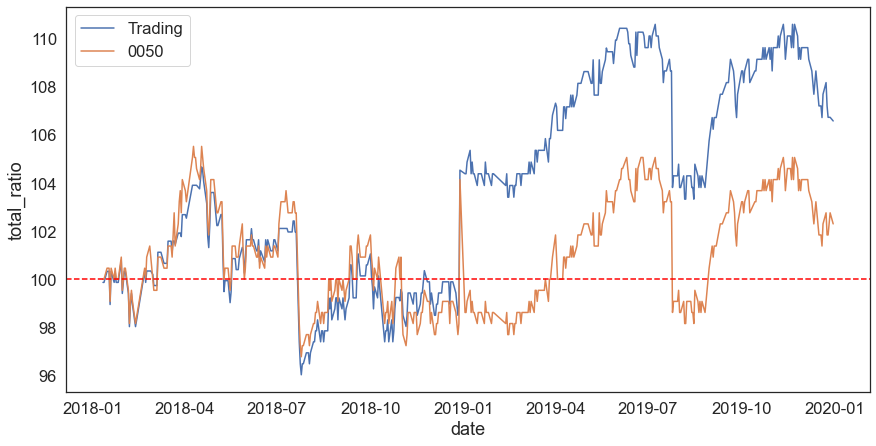

In [121]:
# Valid_Portfolio = load_pickle(os.path.join(gd_root,'Valid_Portfolio.pkl'))
Valid_Portfolio.index = pd.to_datetime(Valid_Portfolio.index)
Valid_Portfolio['total_ratio'] = (Valid_Portfolio['total']/Valid_Portfolio['total'][0])*100
Valid = Valid_Portfolio[time_slide:]
Benchmark = bench_df[time_slide:-1]
Benchmark.index = pd.to_datetime(Benchmark.index)
Benchmark['ratio'] = (Benchmark['Close']/Benchmark['Close'][0])*100
TWII = twii_df[time_slide:-1]
TWII.index = pd.to_datetime(TWII.index)
TWII['ratio'] = (TWII['Close']/TWII['Close'][0])*100

sns.set(style = 'white',font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
# fig.suptitle('Valid Portfolio Assets Change')
sns.lineplot(data = Valid,x=Valid.index,y='total_ratio',label="Trading")
sns.lineplot(data = Benchmark, x =Benchmark.index, y = 'ratio', label="0050")
# sns.lineplot(data = TWII, x = TWII.index, y = 'ratio', label="TWII")

ax.axhline(100, ls='--',color='red')
plt.tight_layout(pad=0)
# plt.savefig('Valid_Portfolio Assets Change.svg', dpi=300)
# plt.savefig('Valid_Portfolio Assets Change.jpg')

## Normalization

In [ ]:
sns.set(style="white", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
fig.suptitle('MarginPurchaseBuy Original')
sns.histplot(bench_df['MarginPurchaseBuy'])

In [ ]:
sns.set(style="white", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
fig.suptitle('MarginPurchaseBuy Normalized')
a = bench_df['MarginPurchaseBuy'].mean()
b = bench_df['MarginPurchaseBuy'].std()
sns.histplot(bench_df['MarginPurchaseBuy'].apply(lambda x : (x-a)/b))


## Smoothing Data Plot

In [ ]:
new_df # expional smooth 過
new_df_ori # 原始

draw = 'Close'
df = pd.concat([new_df[draw], new_df_ori[draw]], axis=1)
df.columns=['exp','ori']
df = df.iloc[-200:]
# display(df.tail())

sns.set(style="white", palette="muted", color_codes=True, font_scale=1.6)

fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
# fig.suptitle(f'Original & Smoothing {draw}')
sns.lineplot(data=df, x=df.index, y='ori', label = 'Original', color='g' ,linestyle='--' ,ax=ax)
sns.lineplot(data=df, x=df.index, y='exp', label = 'Exponential', ax=ax)
# plt.marlegendgins(x=0,y=0)
# plt.(fontsize = 15)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Days")
plt.ylabel(f"{draw}")
plt.tight_layout(pad=0)
plt.savefig('smoothing.svg', dpi=300)
plt.savefig('smoothing.jpg')


# Run Loop

In [ ]:
%%time
print_time(colab)
status(time_slide, feature, days)
# Load the TensorBoard notebook extension
%reload_ext tensorboard

counter = 1
compare_ror = []
train_start = '2013-01-01'
train_end = '2017-12-31'
# stockNum = ['2412']

for stock_num in stockNum:
    tf.keras.backend.clear_session()
    print(counter,str(stock_num),"preprocess")
    # Short Term Model
    day_st = 3
    X_st, y_st, y_st_ori, scaler_x_st, scaler_y_st, _, _ = data_preprocess(stock_num, train_start, train_end, feature, days = day_st)
    train_x_st, train_y_st, val_x_st, val_y_st, price_y_st_tra, price_y_st = input_build(X_st, y_st, y_st_ori)
    model_st = lstm4_reg_v1(train_x_st)
    model_st_name = f'lstm_{stock_num}_{train_x_st.shape[1]}x{train_x_st.shape[2]}_{day_st}d_trainbest.h5'
    history = model_st.fit(train_x_st, train_y_st , 
        verbose=0, epochs = 100, batch_size = batch_size, 
        validation_data=(val_x_st, val_y_st), 
        callbacks = callback(os.path.join(gd_root,model_root,model_st_name)))
    model_st_history = pd.DataFrame(history.history)

    # Long Term Model
    day_lt = 5
    X_lt, y_lt, y_lt_ori, scaler_x_lt, scaler_y_lt, _, _ = data_preprocess(stock_num, train_start, train_end, feature, days = day_lt)
    train_x_lt, train_y_lt, val_x_lt, val_y_lt, price_y_lt_tra, price_y_lt = input_build(X_lt, y_lt, y_lt_ori)
    model_lt = lstm4_reg_v1(train_x_lt)
    model_lt_name = f'lstm_{stock_num}_{train_x_lt.shape[1]}x{train_x_lt.shape[2]}_{day_lt}d_trainbest.h5'
    history = model_lt.fit(train_x_lt, train_y_lt , 
        verbose=0, epochs = 100, batch_size = batch_size, 
        validation_data=(val_x_lt, val_y_lt), 
        callbacks = callback(os.path.join(gd_root,model_root,model_lt_name)))
    model_lt_history = pd.DataFrame(history.history)
    # print(train_x_st.shape,train_y_st.shape,val_x_st.shape,val_y_st.shape)
    # print(train_x_lt.shape,train_y_lt.shape,val_x_lt.shape,val_y_lt.shape)
    
    # Save Model    
    # print(model_st_name)
    # print(model_lt_name)
    model_st.save(os.path.join(gd_root,model_root,model_st_name))
    model_lt.save(os.path.join(gd_root,model_root,model_lt_name))


# setting backtest model

    train_start = '2018-01-01'
    train_end = '2019-12-31'
    # stockNum = ['2412']
    # setting the information of data
    asset_at_the_start = 1000000
    total_asset_present_value = 0
    record_ror = []
    trading_ROR = {}
    portfolio_list = []

    tf.keras.backend.clear_session()
    print(counter,str(stock_num),"trading")
    # Prepare Data
    # todo modify data preprocess, separate scaler & long short terms 
    day = 1
    X, y, y_ori, _, _, df, df_y = data_preprocess(stock_num, train_start, train_end, feature, days = day, train=False,scaler_x=scaler_x_st,scaler_y=scaler_y_st)

# start backtest evaluaion 
    left_money = asset_at_the_start*(1/len(stockNum))
    own_asset = left_money 
    own_stock = 0 
    # money_record = [left_money]*time_slide
    stock_record = [[x,left_money] for x in df.index[:time_slide]]
    # origin_hold_stock = 0 
    X = np.array(X)
    day_st = 3
    day_lt = 5
    model_st_name = f'lstm_{stock_num}_{X.shape[1]}x{X.shape[2]}_{day_st}d_trainbest.h5'
    model_lt_name = f'lstm_{stock_num}_{X.shape[1]}x{X.shape[2]}_{day_lt}d_trainbest.h5'
    model_st = tf.keras.models.load_model(os.path.join(gd_root,model_root,model_st_name))
    model_lt = tf.keras.models.load_model(os.path.join(gd_root,model_root,model_lt_name))
    # print(os.path.join(gd_root,model_root,model_st_name))
    # print(os.path.join(gd_root,model_root,model_lt_name))
    df_trade = df[time_slide:]
    for window in range(len(X)):
#         print(model_st.predict(X[window]))
        price_s = scaler_y_st.inverse_transform(model_st.predict(X[window][np.newaxis,:]))
        price_l = scaler_y_lt.inverse_transform(model_lt.predict(X[window][np.newaxis,:]))
        predict = (price_s,price_l)
        price = df_trade['Close'][window]
        stock_assets, own_stock, left_money, action, pred, price = highlow_strategy(price_s, own_stock, left_money, price)
        stock_record.append([df_trade.index[window], stock_assets, action, pred, price])
    
    daily_assets = pd.DataFrame(stock_record, columns = ['date','assets','action','pred_price','close_price']).set_index('date')  
    portfolio_list.append(daily_assets)
    last_money = stock_record[-1][1]
    left_assets = int(last_money)-(own_asset)
    record_ror.append([str(stock_num), int(last_money), left_assets/own_asset])
    
    # compare to buy & hold strategy
    bench_df = pdr.DataReader(str(stock_num)+'.tw', 'yahoo', start=train_start, end=train_end)
    buyhold_ror = ((bench_df['Close'][-1]/bench_df['Close'][0])-1)*100
    stock_ror = (left_assets*100/(own_asset))

    print(f"{str(counter).zfill(2)} {str(stock_num)} 最後資產： {int(last_money)} 交易報酬率： {stock_ror} % 持有報酬率 {buyhold_ror:.4f} %")
    
    total_asset_present_value += int(last_money)
    trading_ROR[stock_num] = stock_ror
    compare_ror.append([stock_num, stock_ror, buyhold_ror])
    counter+=1

trading_df = pd.DataFrame(compare_ror,columns=['stock','trading ror','buyhold ror'])
trading_df['win'] = trading_df['trading ror'] > trading_df['buyhold ror']
trading_df['diff'] = trading_df['trading ror'] - trading_df['buyhold ror']

print("\n總投資報酬率：", (total_asset_present_value - asset_at_the_start)*100 / asset_at_the_start, "%\n")

Valid_Portfolio = portfolio_list[0].join(portfolio_list[1:])
Valid_Portfolio['total'] = Valid_Portfolio.sum(axis=1)
save_pickle(Valid_Portfolio, os.path.join(gd_root, ror_root, 'Valid_Portfolio.pkl'))
save_pickle(trading_ROR, os.path.join(gd_root, ror_root, 'trading_ROR.pkl'))
ror_df = pd.DataFrame(trading_ROR.items(), columns = ['Stock','trading_ROR'])
ror_df.to_csv(os.path.join(gd_root, ror_root, 'trading_ROR.csv'))
display(trading_df)


2021/11/10 16:59:23
slide winodw: 20 days, 22 features, predict 1 days Close price

1 1101 preprocess

Epoch 00001: val_loss improved from inf to 0.05506, saving model to .\model\lstm_1101_20x22_3d_trainbest.h5

Epoch 00002: val_loss did not improve from 0.05506

Epoch 00003: val_loss improved from 0.05506 to 0.01613, saving model to .\model\lstm_1101_20x22_3d_trainbest.h5

Epoch 00004: val_loss improved from 0.01613 to 0.00206, saving model to .\model\lstm_1101_20x22_3d_trainbest.h5

Epoch 00005: val_loss did not improve from 0.00206

Epoch 00006: val_loss did not improve from 0.00206

Epoch 00007: val_loss did not improve from 0.00206

Epoch 00008: val_loss did not improve from 0.00206

Epoch 00009: val_loss did not improve from 0.00206

Epoch 00010: val_loss did not improve from 0.00206

Epoch 00011: val_loss did not improve from 0.00206

Epoch 00012: val_loss did not improve from 0.00206

Epoch 00013: val_loss did not improve from 0.00206

Epoch 00014: val_loss did not improve from

In [ ]:
%%time

save_path = f'C:/Users/ef9229/desktop/performance_{time_slide}x22_3d.xlsx'
print(save_path)
trading_df.to_excel(save_path)

display(trading_df[trading_df['win']==True])
display(trading_df[trading_df['win']==False])